RRT with Seen and Unseen

Seen is defined as RRT that is able to view the entire grid
Unseen can only see a radius around each node.  Additionally it is unable to see behind obstacles.  It does, however, know what direction the goal is in



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import random
import matplotlib.path as path
from datetime import datetime
from tqdm import tqdm 
import copy

In [2]:
def plot_grid(obstacles, start = None, goal = None, dim = (100,100), tree=None, path = None):
  plt.grid()
  plt.xlim(0,dim[0])
  plt.ylim(0,dim[1])
  
  for obstacle in obstacles:
    obstacle_x = []
    obstacle_y = []
    for i in range(len(obstacle)):
      obstacle_x.append(obstacle[i][0])
      obstacle_y.append(obstacle[i][1])

    obstacle_x.append(obstacle[0][0])
    obstacle_y.append(obstacle[0][1])

    obstacle_x = np.array(obstacle_x)
    obstacle_y = np.array(obstacle_y)

    plt.plot(obstacle_x, obstacle_y, color = "red")

  
  l = [Patch(facecolor='red', label='Obstacle')]

  if tree != None:
    for traj in tree:
      if tree[traj] == None:
        continue
      plt.plot(traj[0],traj[1],'.',color="blue")
      x = [traj[0],tree[traj][0]]
      y = [traj[1],tree[traj][1]]
      plt.plot(x,y,'.',color="blue",linestyle='-')
  if path != None:
    for i in range(len(path)):
      plt.plot(path[i][0],path[i][1],'x',color="yellow")
  if start!=None:
    plt.plot(start[0],start[1],'.',color="orange")
    l.append(Patch(facecolor='orange', label='Start'))

  if goal != None:
    plt.plot(goal[0],goal[1],'.',color="green")
    l.append(Patch(facecolor='green', label='Goal'))



  plt.legend(handles=l)
  
  plt.show()

In [3]:
def dist(q1,q2):
  return math.sqrt((q1[0]-q2[0])*(q1[0]-q2[0])+(q1[1]-q2[1])*(q1[1]-q2[1]))

In [4]:
def detect_collision(q):#true if collision
  for obstacle in obstacles:
    obs = path.Path(obstacle)
    if obs.contains_point(q):
      return True
  return False

In [5]:
def clear_path(q1,q2):#true if collision
  while dist(q1,q2) >= ei:
    v = [ei*(q2[0]-q1[0])/dist(q1,q2),ei*(q2[1]-q1[1])/dist(q1,q2)]
    q1 = (q1[0]+v[0],q1[1]+v[1])
    for obstacle in obstacles:
      obs = path.Path(obstacle)
      if obs.contains_point(q1):
        return True
  return False

In [6]:
def rand_samp():
  r = (random.uniform(0,dim[0]),random.uniform(0,dim[1]))
  while detect_collision(r):
    r = (random.uniform(0,dim[0]),random.uniform(0,dim[1]))
  return r

In [32]:
def path_cost(q,rel_tree):
  g = 0
  while rel_tree[q]!=None:
    g += dist(q,rel_tree[q])
    q = rel_tree[q]
  return g

In [8]:
def find_path(pi_sol, tree):
  if pi_sol == None:
    return None
  path = [pi_sol]
  while tree[pi_sol]!=None:
      pi_sol = tree[pi_sol]
      path.append(pi_sol)
  return list(reversed(path))

In [9]:
def find_q_new_seen(tree, q_rand):#greedy
  q_near = list(tree.keys())[0]
  for q in tree:
    if dist(q,q_rand) < dist(q_near,q_rand):
      q_near = q
  v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
  q_new = (q_near[0]+v[0],q_near[1]+v[1])
  while detect_collision(q_new) or clear_path(q_new,q_near):
    q_rand = rand_samp()
    q_near = list(tree.keys())[0]
    for q in tree:
      if dist(q,q_rand) < dist(q_near,q_rand):
        q_near = q
    v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
    q_new = (q_near[0]+v[0],q_near[1]+v[1])

  if dist(q_new,q_rand)<=delta:
      return q_near, q_rand

  q_test = (q_new[0]+v[0],q_new[1]+v[1])
  while not detect_collision(q_test) and not clear_path(q_test,q_near):
    #print(q_test)
    if dist(q_test,q_rand)<=delta:
      return q_near, q_rand
    q_new = q_test
    q_test = (q_new[0]+v[0],q_new[1]+v[1])
  return q_near, q_new

In [10]:
def find_q_new_seen_nongreedy(tree, q_rand):
  q_near = list(tree.keys())[0]
  for q in tree:
    if dist(q,q_rand) < dist(q_near,q_rand):
      q_near = q
  v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
  q_new = (q_near[0]+v[0],q_near[1]+v[1])
  while detect_collision(q_new) or clear_path(q_new,q_near):
    q_rand = rand_samp()
    q_near = list(tree.keys())[0]
    for q in tree:
      if dist(q,q_rand) < dist(q_near,q_rand):
        q_near = q
    v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
    q_new = (q_near[0]+v[0],q_near[1]+v[1])
  if dist(q_new,q_rand)<=delta:
      return q_near, q_rand

  return q_near, q_new

In [11]:
def find_q_new_unseen_nongreedy(tree, q_rand):
  q_near = list(tree.keys())[0]
  for q in tree:
    if dist(q,q_rand) < dist(q_near,q_rand):
      q_near = q
  v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
  q_new = (q_near[0]+v[0],q_near[1]+v[1])
  while detect_collision(q_new) or clear_path(q_new,q_near) or dist(q_rand,q_near)> V or clear_path(q_near,q_rand):
    q_rand = rand_samp()
    q_near = list(tree.keys())[0]
    for q in tree:
      if dist(q,q_rand) < dist(q_near,q_rand):
        q_near = q
    v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
    q_new = (q_near[0]+v[0],q_near[1]+v[1])

  if dist(q_new,q_rand)<=delta:
      return q_near, q_rand

  return q_near, q_new

In [12]:
def RRT_seen():
  start_time = datetime.now()
  tree = {start:None}
  for i in range(N):
    #print(i)
    b = random.random()
    if bias >=b:
      q_rand = goal
    else:
      q_rand = rand_samp()
    q_near,q_new = find_q_new_seen(tree,q_rand)
    tree[q_new] = q_near
    if dist(q_new, goal) <= delta:
      current_time = datetime.now()
      print("Path time" + str(current_time-start_time))
      print("Path cost " + str(path_cost(q_new,tree)))
      return find_path(q_new,tree), tree
  print("No Path")
  return None, tree

In [ ]:
def RRT_seen_nongreedy():
  #start_time = datetime.now()
  tree = {start:None}
  for i in range(N):
    #print(i)
    b = random.random()
    if bias >=b:
      q_rand = goal
    else:
      q_rand = rand_samp()
    q_near,q_new = find_q_new_seen_nongreedy(tree,q_rand)
    tree[q_new] = q_near
    if dist(q_new, goal) <= delta:
      #current_time = datetime.now()
      #print("Path time" + str(current_time-start_time))
      #print("Path cost " + str(path_cost(q_new,tree)))
      return find_path(q_new,tree), tree, i+1
  #print("No Path")
  return None, tree, i+1

In [ ]:
def RRT_unseen_nongreedy():
  #start_time = datetime.now()
  tree = {start:None}
  for i in range(N):
    #print(i)
    b = random.random()
    if bias >=b:
      q_rand = goal
      q_near = list(tree.keys())[0]
      for q in tree:
        if dist(q,q_rand) < dist(q_near,q_rand):
          q_near = q
      v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
      q_rand = (q_near[0]+v[0],q_near[1]+v[1])
    else:
      q_rand = rand_samp()
    q_near,q_new = find_q_new_unseen_nongreedy(tree,q_rand)
    tree[q_new] = q_near
    if dist(q_new, goal) <= delta:
      #current_time = datetime.now()
      #print("Path time" + str(current_time-start_time))
      #print("Path cost " + str(path_cost(q_new,tree)))
      return find_path(q_new,tree), tree, i+1
  #print("No Path")
  return None, tree, i+1

In [39]:
def RRT_star_unseen_nongreedy():
  #start_time = datetime.now()
  tree = {start:None}
  for i in range(N):
    #print(i)
    b = random.random()
    if bias >=b:
      q_rand = goal
      q_near = list(tree.keys())[0]
      for q in tree:
        if dist(q,q_rand) < dist(q_near,q_rand):
          q_near = q
      v = [delta*(q_rand[0]-q_near[0])/dist(q_rand,q_near),delta*(q_rand[1]-q_near[1])/dist(q_rand,q_near)]
      q_rand = (q_near[0]+v[0],q_near[1]+v[1])
    else:
      q_rand = rand_samp()
    q_near,q_new = find_q_new_unseen_nongreedy(tree,q_rand)

    q_cheap = q_near
    temp_tree = copy.deepcopy(tree)
    temp_tree[q_new] = q_cheap
    best_cost = path_cost(q_new, temp_tree)
    neighbor = []
    for q in tree:
      if dist(q, q_new) < V:
        neighbor.append(q)

    for q in neighbor:
      temp_tree[q_new] = q
      if path_cost(q_new, temp_tree) < best_cost and not clear_path(q_new, q):
        q_cheap = q
        best_cost = path_cost(q_new, temp_tree)

    q_near = q_cheap
    tree[q_new] = q_near

    if dist(q_new, goal) <= delta:
      #current_time = datetime.now()
      #print("Path time" + str(current_time-start_time))
      #print("Path cost " + str(path_cost(q_new,tree)))
      return find_path(q_new,tree), tree, i+1
  #print("No Path")
  return None, tree, i+1

In [14]:
#config
N = 10000
V = 4 #vision radius
bn = 3
ei = 0.5 #edge increment
delta = 1
bias = 0.05

In [43]:
def detect_collision_grid(q,c_obs):#true if collision
  for obstacle in c_obs:
    obs = path.Path(obstacle)
    if obs.contains_point(q):
      return True
  return False

In [44]:
def clear_path_grid(q1,q2,c_obs):#true if collision
  ei = 0.1
  while dist(q1,q2) >= ei:
    v = [ei*(q2[0]-q1[0])/dist(q1,q2),ei*(q2[1]-q1[1])/dist(q1,q2)]
    q1 = (q1[0]+v[0],q1[1]+v[1])
    for obstacle in c_obs:
      obs = path.Path(obstacle)
      if obs.contains_point(q1):
        return True
  return False

In [45]:
def generate_grid(dim = (100,100)):
  num_obs = random.randint(1,3)
  c_obs = []
  for i in range(num_obs):
    temp_obs = []
    num_sides = 3
    obs_cand=[random.randint(0,dim[0]-1),random.randint(0,dim[1]-1)]
    while detect_collision_grid(obs_cand,c_obs):
      obs_cand=[random.randint(0,dim[0]-1),random.randint(0,dim[1]-1)]
    temp_obs.append(obs_cand)
    prev_obs = obs_cand
    first_obs = obs_cand
    for j in range(1,num_sides):
      obs_cand=[random.randint(0,dim[0]-1),random.randint(0,dim[1]-1)]
      while detect_collision_grid(obs_cand,c_obs) or clear_path_grid(prev_obs,obs_cand,c_obs) or clear_path_grid(first_obs,obs_cand,c_obs):
        obs_cand=[random.randint(0,dim[0]-1),random.randint(0,dim[1]-1)]
      temp_obs.append(obs_cand)
      prev_obs = obs_cand
    c_obs.append(temp_obs)
  start = (random.randint(0,dim[0]-1),random.randint(0,dim[1]-1))
  while detect_collision_grid(start,c_obs):
    start = (random.randint(0,dim[0]-1),random.randint(0,dim[1]-1))
  goal = (random.randint(0,dim[0]-1),random.randint(0,dim[1]-1))
  while detect_collision_grid(goal,c_obs):
    goal = (random.randint(0,dim[0]-1),random.randint(0,dim[1]-1))
  return c_obs, start, goal

In [46]:
num_trials = 50
dim = (100,100)
success_rate = 0
cost = 0
iter = 0
for trial in tqdm(range(num_trials)):
  obstacles, start, goal = generate_grid()
  obstacles = np.array(obstacles,dtype=object)
  path_i, tree_i, iter_i = RRT_star_unseen_nongreedy()
  if path_i != None:
    success_rate += 1
    cost += path_cost(path_i[len(path_i)-1],tree_i)
    iter += iter_i
if success_rate == 0:
  cost = -1
  iter = -1
else:
  cost /= success_rate
  iter /= success_rate
success_rate /= num_trials

print("\nSuccess Rate: " + str(success_rate))
print("Average Iterations:  " + str(iter))
print("Average Cost: " + str(cost))
#plot_grid(obstacles,start,goal,dim,tree_i,path_i)

100%|██████████| 50/50 [1:20:52<00:00, 97.04s/it] 


Success Rate: 0.9
Average Iterations:  2112.8888888888887
Average Cost: 61.62585833787444


In [ ]:
num_trials = 50
dim = (100,100)
success_rate = 0
cost = 0
iter = 0
for trial in tqdm(range(num_trials)):
  obstacles, start, goal = generate_grid()
  obstacles = np.array(obstacles,dtype=object)
  path_i, tree_i, iter_i = RRT_seen_nongreedy()
  if path_i != None:
    success_rate += 1
    cost += path_cost(path_i[len(path_i)-1],tree_i)
    iter += iter_i
if success_rate == 0:
  cost = -1
  iter = -1
else:
  cost /= success_rate
  iter /= success_rate
success_rate /= num_trials

print("\nSuccess Rate: " + str(success_rate))
print("Average Iterations:  " + str(iter))
print("Average Cost: " + str(cost))
#plot_grid(obstacles,start,goal,dim,tree_i,path_i)

100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


Success Rate: 0.98
Average Iterations:  419.83673469387753
Average Cost: 77.37506555822183


In [ ]:
path_1, tree_1 = RRT_seen_nongreedy()

Path time0:00:00.084610
Path cost 105.56527945938687


In [41]:
path_1, tree_1, iter_1 = RRT_star_unseen_nongreedy()

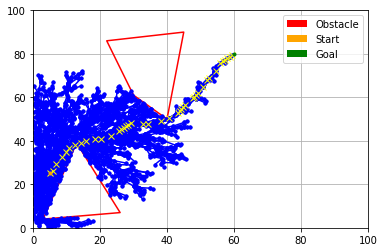

In [42]:
tree = tree_1
p_1 = path_1
plot_grid(obstacles,start,goal,dim,tree,p_1)

In [15]:
#Grid 1
obstacles = np.array([[[3,4],[26,7],[13,39]],[[40,50],[45,90],[22,86],[30,61]]],dtype=object)
start = (5,25)
goal = (60,80)
dim = (100,100)
grid = np.array([obstacles,start,goal,dim],dtype=object)

#tree = {start:None,(10,50):start, (20,50):(10,50)}
#path = [start,(10,50)]